In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# FUNÇAO QUE CONVERTE O FORMATO DO dtEVENTO NO ARQUIVO BASE_TREINAMENTO.CSV
# O FORMATO DAS DATAS NO CSV É DIFERENTE DAQUELE QUE ESTA NO NOME DOS ARQUIVOS
def timeConverter(DataFrame):
    dtEvento = []
    for i in range(0, 6966):
        aux = DataFrame.iloc[i, 4].replace(' ', '_')
        aux = aux.replace('-', '')
        dtEvento.append(aux.replace(':', ''))
        
    return dtEvento

# FUNÇAO QUE CONVERTE OS VALORES DE STRING PARA FLOAT
# OS DADOS DISPONIBILIZADOS ESTÃO TODOS EM TXT
def stringToFloat(dataFrame, nome):
    dataFrame[nome] = pd.to_numeric(dataFrame[nome], downcast="float")

    
# FUNÇAO QUE OBTEM OS DADOS DE CORRENTE RMS DE CADA UMA DAS ASSINATURAS
def getDados(Leitura, tipoDeDado):
    f = open(Leitura) # pode ser adicionado o .txt, mas ele ja esta presente nas colunas
    lines = f.readlines()
    i = 0
    while(i < len(lines)):
        i += 1
        if(lines[i] == "***End_of_Header***\n"):
            break
    
    Inicio = i + 2
    with open(Leitura) as f:
        linhas = f.readlines()[Inicio:]
    df = pd.DataFrame(linhas)
    df = df[0].str.split('\t', expand=True)
    stringToFloat(df, 2)
    
    if(tipoDeDado == 'tempo'):
        return np.array(df[0])
    if(tipoDeDado == 'corrente'):
        return np.array(df[1])
    if(tipoDeDado == 'correnteRMS'):
        return np.array(df[2])
    
def getLeituras(maquinas, amostragem, maquinaAnalisada):
    for i in range(0, int(len(maquinas.index))):  
        try:
            leitura = getDados(maquinas['DS_LOCAL_INSTALACAO'].iloc[i] + '/' + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt', 'correnteRMS')
        except FileNotFoundError:
            print("Leitura nao encontrada: " + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt')
        else:
            DF = pd.DataFrame(leitura, columns=[maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i]])
            stringToFloat(DF, maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i])
            DF = DF.transpose()
            maquinaAnalisada = pd.concat([maquinaAnalisada, DF,])
    maquinaAnalisada = maquinaAnalisada.transpose()
        
    return maquinaAnalisada
        

In [ ]:
# Filtro de dados

# FUNÇAO QUE FILTRA AS LEITURAS ZERADAS OU QUE APRESENTAM COMPORTAMENTO DE PEQUENOS RUIDOS
# EXEMPLO DE LEITURA EM QUE ISSO ACONTECE: MCH004W21A_R_20190906_104250
def filtroLeiturasRuido(Maquinas):
    max = 0
    leiturasRuido = []
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 1):
            leiturasRuido.append(Maquinas.columns[i])
        max = 0
    
    Maquinas = Maquinas.drop(leiturasRuido, axis=1)
    return Maquinas 

# FUNÇAO QUE CORRIGE AS LEITURAS CUJAS CORRENTES SOFRERAM A REDUÇAO PELO FILTRO QUE O GUILHERME COMENTOU
def corrigeCorrentes(Maquinas, fatorDeCorrecao):
    max = 0
    aux = 0
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 12):
            Maquinas[Maquinas.columns[i]] = fatorDeCorrecao*Maquinas[Maquinas.columns[i]]
        max = 0
    
    return Maquinas

# FILTRO DE LEITURAS DESLOCADAS PARA TRAÇAR A MEDIA
# Se o filtro não é utilizado, as curvas médias apresentam um comportamento bizarro, as médias não consideram deslocamento
def filtroLeituraDeslocada(leituras, dfPontosFase):
    leiturasFiltradas = []
    if(dfPontosFase.iloc[0,0] != None):
        min = dfPontosFase.iloc[0,0]
        for i in range(0, len(dfPontosFase.columns)):
            if(min > dfPontosFase.iloc[0, i]):
                min = dfPontosFase.iloc[0, i]
        
        for i in range(0, len(dfPontosFase.columns)):
            if(dfPontosFase.iloc[0, i] > 1.5*min):
                leiturasFiltradas.append(dfPontosFase.columns[i])

        leituras = leituras.drop(leiturasFiltradas, axis=1)
    else:
        print('Nao ha leituras normais')
    return leituras

In [ ]:
# Cálculo com Dados

def Derivada(valor, intervalo):
    derivada = np.diff(valor.values)/intervalo    #pode ser alterado pra utilizar a coluna do tempo ao inves de um intervalo 
    return derivada
    pd.set_option('display.max_rows', 300)
    
def calculaFases(corrente, intervalo):
    deriv = np.array(Derivada(corrente, intervalo))
    corrente = np.array(corrente)
    fimFases = []
    fimFase0 = np.argmax(deriv[50:]>10) + 50
    fimFases.append(fimFase0)
    topo = 0
    topo = np.argmax(deriv[fimFase0:]<0)
    topo = topo + fimFase0
    
   
    metadeCorrente = np.argmax(corrente[topo:]<(corrente[topo]/2))  + topo
    fimFase1 = np.argmax(deriv[metadeCorrente + 1:]>-4)
    fimFase1 = fimFase1 + metadeCorrente + int(0.04545/intervalo)
    fimFases.append(fimFase1)
    #
    #descomentar quado se tratar de leituras novas
    #result = np.where(deriv[fimFase1 + int(0.15/intervalo):] == np.amin(deriv[fimFase1 + int(0.15/intervalo):fimFase1 + int(0.5/intervalo)]))
    #fimFase2 = result[0][0] + int(0.04/intervalo) + fimFase1 + int(0.15/intervalo)
    #fimFases.append(fimFase2)
    result = np.where(deriv == np.amax(deriv[fimFase1 + int(0.9/intervalo):fimFase1 + int(2/intervalo)]))
    fimFase3 = result[0][0] - int(0.04040/intervalo)
    fimFases.append(fimFase3)
    

    fimCorrente = np.argmax(corrente[fimFase3:]<(corrente[topo]/20)) + fimFase3
    fimFase4 = np.argmax(deriv[fimCorrente + 1:] > -1)
    fimFase4 = fimCorrente + fimFase4 - int(0.02020/intervalo)
    fimFases.append(fimFase4)
    return (fimFases)

# FUNÇAO QUE GERA UM GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
def geraAssinaturaMedia(maquinaEmAnalise, parametroStd):
    assinaturaNormal = pd.DataFrame()
    dfex = maquinaEmAnalise
    assinaturaNormal = assinaturaNormal.assign(Tempo = lambda x: dfex['t (s)']) 
    dfex = dfex.drop("t (s)", axis=1)
    stdNormal = dfex.std(axis=1)
    mediaNormal = dfex.mean(axis=1)
    assinaturaNormal['Std'] = stdNormal
    assinaturaNormal['Média'] = mediaNormal
    assinaturaNormal['Curva mínima'] = mediaNormal - parametroStd*stdNormal
    assinaturaNormal['Curva máxima'] = mediaNormal + parametroStd*stdNormal
    dfex.shape
    for i in range(0, len(assinaturaNormal.index)):
        if(assinaturaNormal.iloc[i, 3] < 0):
            assinaturaNormal.iloc[i, 3] = 0
      
    return assinaturaNormal

def geraTabelaEQM(mediaTotal, stdTotal):
    valores = []
    valores.append(mediaTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] - stdTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] + stdTotal.iloc[0])
    valoresDF = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase 0'])
    valoresDF = valoresDF.transpose()
    valores = []
    for i in range(1, 6):
        valores.append(mediaTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] - stdTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] + stdTotal.iloc[i])
        if(i < 5):
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase ' + str(i)])
        else:
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Total'])
        valores = []
        valoresAux = valoresAux.transpose()
        valoresDF = pd.concat([valoresDF, valoresAux, ])
    return valoresDF

In [ ]:
%%time
pd.options.display.max_rows = 8200
pd.options.display.max_columns = 4000
amostragem = 8182
# Para escolher qual delas analisar, basta trocar o valor da variável abaixo
fabricante = 'KY NS-AM'
#fabricante = 'KY SLNS-1A'

baseDF = pd.read_csv('BASE_TREINAMENTO.csv', sep=",")
dt = timeConverter(baseDF)
dtEvento = pd.DataFrame(dt, columns=['DT_EVENTO'])
baseDF = baseDF.assign(DT_EVENTO=dtEvento['DT_EVENTO'])
maquinas = baseDF.loc[(baseDF["DS_FABRICANTE"] == fabricante)]
#maquinas.to_csv(fabricante + '.csv')

dt = getDados('H004/MCH004W21A_N_20190817_190721.txt', 'tempo')
maquinaAnalisada = pd.DataFrame(dt, columns=['t (s)']) 
stringToFloat(maquinaAnalisada, 't (s)')
maquinaAnalisada = maquinaAnalisada.transpose()

In [ ]:
%%time
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

maquinasPorEstado = []
maquinasPorEstado.append(getLeituras(maquinasSemDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasFalha, amostragem, maquinaAnalisada))

In [7]:
# Máquinas KY NS-AM
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

In [11]:
%%time
for i in range(0,3):  
    maquinasPorEstado[i] = filtroLeiturasRuido(maquinasPorEstado[i])
    
fatorDeCorrecao = 1.52 # o fator de correçao ainda é um valor estimado, não foi um dado fornecido pela Vale
for i in range(0,3):  
    maquinasPorEstado[i] = corrigeCorrentes(maquinasPorEstado[i], fatorDeCorrecao)

CPU times: user 59.7 s, sys: 100 ms, total: 59.8 s
Wall time: 59.9 s


In [16]:
%%time
PontosFase = []
dfPontosFase = pd.DataFrame(index =['Fim do Inicio', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for rotulo in range(0, 3):
    for col in maquinasPorEstado[rotulo]:
        if (col != 't (s)'):
            pontos = calculaFases(maquinasPorEstado[rotulo][col], 0.00101)
            dfPontosFase[col] = pontos
    PontosFase.append(dfPontosFase)
    dfPontosFase = pd.DataFrame(index =['Fim do Inicio', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

CPU times: user 499 ms, sys: 3.26 ms, total: 502 ms
Wall time: 501 ms


In [14]:
def plotaMarcado(corrente, fimDeFase, Leitura):
    corrente.plot(kind='line')
    plt.annotate('fim da fase 0', xy=(fimDeFase[0], corrente.iloc[fimDeFase[0]]), xytext=(1000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 1', xy=(fimDeFase[1], corrente.iloc[fimDeFase[1]]), xytext=(1100, 2.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    #plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(1300, 5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(4000, 7), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 3', xy=(fimDeFase[3], corrente.iloc[fimDeFase[3]]), xytext=(6000, 2), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.title(Leitura)
    plt.show()

In [15]:
leitura = 'MCH006W21B_20200204_094643'
plotaMarcado(maquinasPorEstado[1][leitura], dfPontosFase[leitura], leitura)

KeyError: 'MCH006W21B_20200204_094643'

CPU times: user 321 ms, sys: 5.41 ms, total: 326 ms
Wall time: 326 ms


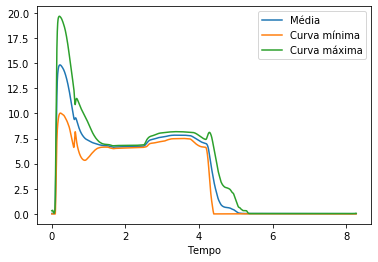

In [18]:
%%time
# SELECIONA DADOS E PLOTA O GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
parametroStd = 1
normal = geraAssinaturaMedia(maquinasPorEstado[0], parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

CPU times: user 252 ms, sys: 5.86 ms, total: 258 ms
Wall time: 257 ms


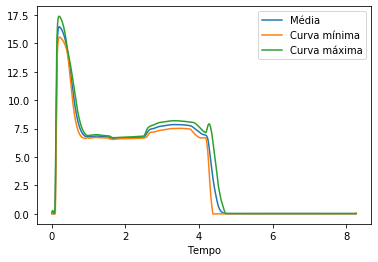

In [20]:
%%time
# MEDIA NORMAL COM FILTRO DE LEITURAS DESLOCADAS
normaisDeslocamentoFiltrado = filtroLeituraDeslocada(maquinasPorEstado[0], PontosFase[0])
parametroStd = 1
normal = geraAssinaturaMedia(normaisDeslocamentoFiltrado, parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

In [21]:
# FUNCAO QUE CALCULA AS DISTANCIAS PONTO A PONTO E A SOMA DE TODAS ELAS POR FASE, CONSIDERANDO AS LEITURAS DESLOCADAS
def CalculaDistancia(normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0

    for i in range(1, len(leituras.columns)):
        if(dfPontosFase.iloc[0, i-1] > 1.1*int(pontosMedia.iloc[0])): # avalia deslocamento
            for j in range(0, dfPontosFase.iloc[0, i-1]):
                dist += math.sqrt((leituras.iloc[j, i] - mediaInicio)**2)
                if(j == dfPontosFase.iloc[0, i-1]-1):
                    distanciaFases.append(dist/(dfPontosFase.iloc[0, i-1]))
                    total += dist
                    dist = 0
        else:
            for j in range(0, int(pontosMedia['Fim do Inicio'])):
                dist += math.sqrt((leituras.iloc[j, i] - normal.iloc[j, 2])**2)
                if(j == int(pontosMedia['Fim do Inicio'])-1):
                    distanciaFases.append(dist/(int(pontosMedia['Fim do Inicio'])))
                    total += dist
                    dist = 0
          
        # Calcula distancias considerando a quantidade de pontos que ha na assinatura normal entre uma fase e 
        # a fase conseguinte para padronizar o tamanho das fases. Esse trecho considera qualquer inicio para a primeira
        # fase, seja ele deslocado ou nao, e faz a comparacao a partir dessa diferença de pontos que ha para a normal
        for j in range(0, int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio'])):
            dist += math.sqrt((leituras.iloc[dfPontosFase.iloc[0, i-1] + j, i] - normal.iloc[int(pontosMedia['Fim do Inicio']) + j, 2])**2)
            #if(leituras.columns[i] == '20191002_104002'):
             #   print(j)
              #  print(leituras.iloc[dfPontosFase.iloc[0, i-1] + j, i])
               # print(normal.iloc[int(pontosMedia['Fim do Inicio']) + j, 2])
                
            if(j == int(dfPontosFase.iloc[1][i-1]) - int(dfPontosFase.iloc[0][i-1])):
                distanciaFases.append(dist/(int(dfPontosFase.iloc[1][i-1]) - int(dfPontosFase.iloc[0][i-1])))
                total += dist
                dist = 0   

            if(j == int(dfPontosFase.iloc[2][i-1]) - int(dfPontosFase.iloc[0][i-1])):
                distanciaFases.append(dist/(int(dfPontosFase.iloc[2][i-1]) - int(dfPontosFase.iloc[0][i-1])))
                total += dist
                dist = 0

            if(j == int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio']) - 1):
                distanciaFases.append(dist/(int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio']) - 1))
                total += dist
                dist = 0
        
        if(dfPontosFase.iloc[0, i-1] > 1.1*int(pontosMedia.iloc[0])): #avalia deslocamento
            for j in range(dfPontosFase.iloc[3, i-1], amostragem):
                dist += math.sqrt((leituras.iloc[j, i] - mediaFim)**2)
                if(j == amostragem-1):
                    distanciaFases.append(dist/(amostragem - dfPontosFase.iloc[3, i-1]))
                    total += dist
                    dist = 0

        else:
            for j in range(amostragem - int(pontosMedia['Fim da Fase 3']), amostragem):
                dist += math.sqrt((leituras.iloc[j, i] - normal.iloc[j, 2])**2)
                if(j == amostragem - 1):
                    distanciaFases.append(dist/(amostragem - int(pontosMedia['Fim da Fase 3'])))
                    total += dist
                    dist = 0

        distanciaFases.append(total/amostragem)
        total = 0

        DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
        DF = DF.transpose()
        distanciasDF = pd.concat([distanciasDF, DF,])
        distanciaFases = []
    
    distanciasDF = distanciasDF.transpose()
    return distanciasDF

In [21]:
# FUNCAO QUE CALCULA AS DISTANCIAS PONTO A PONTO E A SOMA DE TODAS ELAS POR FASE, CONSIDERANDO AS LEITURAS DESLOCADAS
def CalculaDistancia(normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0

    for i in range(1, len(leituras.columns)):
        for j in range(0, dfPontosFase.iloc[0, i-1]):
            dist += (leituras.iloc[j, i] - mediaInicio)**2
            if(j == dfPontosFase.iloc[0, i-1]-1):
                distanciaFases.append(dist/(dfPontosFase.iloc[0, i-1]))
                total += dist
                dist = 0
          
        for j in range(0, int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio'])):
            dist += (leituras.iloc[dfPontosFase.iloc[0, i-1] + j, i] - normal.iloc[int(pontosMedia['Fim do Inicio']) + j, 2])**2
                
            if(j == int(dfPontosFase.iloc[1][i-1]) - int(dfPontosFase.iloc[0][i-1])):
                distanciaFases.append(dist/(int(dfPontosFase.iloc[1][i-1]) - int(dfPontosFase.iloc[0][i-1])))
                total += dist
                dist = 0   

            if(j == int(dfPontosFase.iloc[2][i-1]) - int(dfPontosFase.iloc[0][i-1])):
                distanciaFases.append(dist/(int(dfPontosFase.iloc[2][i-1]) - int(dfPontosFase.iloc[0][i-1])))
                total += dist
                dist = 0

            if(j == int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio']) - 1):
                distanciaFases.append(dist/(int(pontosMedia['Fim da Fase 3']) - int(pontosMedia['Fim do Inicio']) - 1))
                total += dist
                dist = 0
        
        for j in range(dfPontosFase.iloc[3, i-1], amostragem):
            dist += (leituras.iloc[j, i] - mediaFim)**2
            if(j == amostragem-1):
                distanciaFases.append(dist/(amostragem - dfPontosFase.iloc[3, i-1]))
                total += dist
                dist = 0

        distanciaFases.append(total/amostragem)
        total = 0

        DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
        DF = DF.transpose()
        distanciasDF = pd.concat([distanciasDF, DF,])
        distanciaFases = []
    
    distanciasDF = distanciasDF.transpose()
    return distanciasDF

In [22]:
%%time
# CALCULA MEDIA DOS FINS DE CADA FASE PARA LEITURA NORMAL FILTRADA
dfPontosFase = pd.DataFrame(index =['Fim do Inicio', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for col in normaisDeslocamentoFiltrado:
    if (col != 't (s)'):
        pontos = calculaFases(normaisDeslocamentoFiltrado[col], 0.00101)
        dfPontosFase[col] = pontos


#calcula os pontos de troca de fase da assinatura
pontosMediaFilt = dfPontosFase.mean(axis=1)
print (pontosMediaFilt)

# Esse bloco calcula uma media dos valores normais para a fase inicial para ser comparada com as leituras em
# analise, a escolha desse metodo serve para contornar os casos em que o inicio da fase 1 esta deslocado.
mediaInicio = mediaFim = 0

for c in range(0, int(pontosMediaFilt.iloc[0])):
    mediaInicio += normal.iloc[c, 2]
mediaInicio = mediaInicio/int(pontosMediaFilt.iloc[0])
    
# Esse bloco e analogo ao primeiro, fazendo o mesmo processo mas para a fase final
for d in range(int(pontosMediaFilt.iloc[3]), amostragem):
    mediaFim += normal.iloc[d, 2]
mediaFim = mediaFim/int(pontosMediaFilt.iloc[3])

Fim do Inicio      86.631119
Fim da Fase 1     872.622378
Fim da Fase 2    2518.650350
Fim da Fase 3    4399.582168
dtype: float64
CPU times: user 333 ms, sys: 2.01 ms, total: 335 ms
Wall time: 334 ms


In [24]:
%%time
# Trecho que gera o csv com os valores normais de corrente da house analisada
normal.to_csv('normal' + fabricante + '.csv')

# Trecho que gera o csv com os valores de pontos médio para cada fim de fase da assinatura normal
pontosMediaFilt.to_csv('pontosMedia'+ fabricante + '.csv')

CPU times: user 50 ms, sys: 2.57 ms, total: 52.5 ms
Wall time: 53.4 ms


In [ ]:
%%time
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS NORMAIS
distanciasNormais = CalculaDistancia(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasNormais = distanciasNormais.transpose()
mediaTotalNormal= distanciasNormais.mean(axis=0)
stdTotalNormal= distanciasNormais.std(axis=0)
distanciasNormais['rotulo'] = 0
distanciasNormais

In [26]:
%%time
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS NORMAIS
distanciasNormais = CalculaDistancia(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasNormais = distanciasNormais.transpose()
mediaTotalNormal= distanciasNormais.mean(axis=0)
stdTotalNormal= distanciasNormais.std(axis=0)
distanciasNormais['rotulo'] = 0
distanciasNormais

CPU times: user 1h 23min 17s, sys: 23.2 s, total: 1h 23min 41s
Wall time: 1h 23min 31s


,EQM Fase 0,EQM Fase 1,EQM Fase 2,EQM Fase 3,EQM Fase 4,EQM Total,rotulo
MCH006W21A_20190821_054530,0.015276,0.835315,0.068240,0.319781,0.367720,0.447020,0
MCH006W21A_20190821_082644,0.015138,0.997563,0.065758,0.312319,0.403976,0.476588,0
MCH006W21A_20190821_085516,0.006745,0.949472,0.065998,0.311275,0.420478,0.482471,0
MCH006W21A_20190821_184146,0.013842,0.724218,0.072696,0.461537,0.625986,0.628079,0
MCH006W21A_20190822_103101,0.009560,0.338764,0.714607,0.473334,0.715300,0.655845,0
MCH006W21A_20190822_111935,2.882419,0.520218,0.021435,0.144906,0.141685,0.232275,0
MCH006W21A_20190822_112050,0.007874,0.574077,0.025569,0.133503,0.136092,0.198434,0
MCH006W21A_20190822_112214,0.012111,0.599712,0.034846,0.139642,0.141393,0.211007,0
MCH006W21A_20190822_120243,0.007075,0.513404,0.032050,0.135859,0.178539,0.215704,0
MCH006W21A_20190822_130652,0.014482,0.614971,0.035333,0.150198,0.157145,0.226504,0


In [27]:
valoresNormais = geraTabelaEQM(mediaTotalNormal, stdTotalNormal)
valoresNormais

,Média,Mínima,Máxima
EQM Normal Fase 0,0.022199,-0.130293,0.174692
EQM Normal Fase 1,0.611716,0.351218,0.872214
EQM Normal Fase 2,0.062896,-0.006057,0.131850
EQM Normal Fase 3,0.223373,0.137123,0.309623
EQM Normal Fase 4,0.189279,0.073016,0.305542
EQM Normal Total,0.283174,0.185490,0.380858


In [28]:
%%time
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS DEFEITUOSAS
distanciasDefeito = CalculaDistancia(normal, maquinasPorEstado[1], PontosFase[1], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasDefeito = distanciasDefeito.transpose()
mediaTotalDefeito= distanciasDefeito.mean(axis=0)
stdTotalDefeito= distanciasDefeito.std(axis=0)
distanciasDefeito['rotulo'] = 1
distanciasDefeito

ValueError: Shape of passed values is (5, 1), indices imply (6, 1)

In [29]:
valoresDefeito = geraTabelaEQM(mediaTotalDefeito, stdTotalDefeito)
valoresDefeito

NameError: name 'mediaTotalDefeito' is not defined

In [ ]:
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS COM FALHA
distanciasFalha = CalculaDistancia(normal, maquinasPorEstado[2], PontosFase[2], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasFalha = distanciasFalha.transpose()
mediaTotalFalha= distanciasFalha.mean(axis=0)
stdTotalFalha= distanciasFalha.std(axis=0)

distanciasFalha

In [ ]:
valoresFalha = geraTabelaEQM(mediaTotalFalha, stdTotalFalha)
valoresFalha

In [ ]:
valoresNormais = pd.concat([valoresNormais, valoresDefeito,])

valoresNormais = pd.concat([valoresNormais, valoresFalha,])

# Gera o csv com os parâmetros de eqm
valoresNormais.to_csv('eqmTreinamento'+ fabricante + '.csv')

In [ ]:
#junta os dataframes de normal e defeito
principal = pd.concat([distanciasNormais, distanciasDefeito])

In [ ]:
principal

In [ ]:
#divide em dataframe de treino e teste
from sklearn.model_selection import train_test_split
train, test = train_test_split(principal, random_state=0)

In [ ]:
#configura as features a ser analisadas, e treina o modelo
from sklearn.linear_model import LogisticRegression
feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4']
X_treino = train.loc[:, feature_cols]
y_treino = train.rotulo
X_teste = test.loc[:, feature_cols]
y_teste = test.rotulo
modelo = LogisticRegression()
modelo.fit(X_treino, y_treino)

In [ ]:
#testa a acuracia na base de treino e teste
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(modelo.score(X_treino, y_treino)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(modelo.score(X_teste, y_teste)))

In [ ]:
X_treino.shape

In [ ]:
predictions = modelo.predict_proba(X_teste)

In [ ]:
predictions

In [ ]:
y_teste

In [ ]:
modelo.get_params()

In [ ]:
print (modelo.coef_)